In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

import counts_statistics_qpe as cs
import phase_estimation_functions as qpe
import verification_functions as verif
from densitymatrix import DM
import glob

In [3]:
"""
START DATA ANALYSIS
"""
####################### VERIFICATION ANALYSIS #################
data_dir = r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\with_Certification"
os.chdir(data_dir)
filenames  = [i for i in glob.glob("QPE*")]
n_qubits = 4
input_state = "Plus" #or GHZ # This will specify in which folder we want to save the figures

def sorting_index(filename: str):
    x, y = filename[:-len(".txt")].split("_")[1:]
    return int(y), int(x)

# Defining the stabilizers we want to stabilize and respective signs
stabilizers = [ "iiii", "zzii", "izzi", "iizz", "xxxx", "zizi", "iziz", "zzzz", "xyyx", "yxyx", "xxyy", "yyxx", "ziiz", "yxxy", "xyxy", "yyyy"]
#stabilizers = ["xxxx", "yyxx", "xyyx", "xxyy"]
stab_sign = [1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , -1 , -1 , -1 , -1 , 1 , -1 , -1 , 1 ]
#stab_sign = [1 , -1, -1 , -1]
STABILIZER_TO_INDEX = {stab: i for i, stab in enumerate(stabilizers)}        

In [9]:
"""
Uncomment if ["n_samples", "n_samples_error", "p_pass", "p_pass_error"] txt files haven't been generated
Gets the p_pass list the counts in data_dirs folder
""" 
for index, file in enumerate(filenames):
    file_dir = f"{data_dir}\{file}\counts"
    os.chdir(file_dir)
    files = [i for i in glob.glob("ABCD=*.txt")]
    files.sort(key = sorting_index)

    n_rounds = sorting_index(files[-1])[0] + 1
    ROUND_TO_FILES = defaultdict(list)
    for f in files:
         round_ = sorting_index(f)[0]
         ROUND_TO_FILES[round_].append(f)

    for i in tqdm(range(n_rounds)):
        writting_dir = f"{data_dir}\{file}\stats_originalverif\\v_round={i}"
        os.makedirs(f"{writting_dir}", exist_ok=True)

        stats = cs.Operartors_Statistics(n_qubits, stabilizers, stab_sign, STABILIZER_TO_INDEX, ROUND_TO_FILES[i], file_dir, qubit=None, state='GHZ')
        samples_evolution = np.arange(1, stats.n_loops+1, 1)
        p_pass_list, n_samples_list = stats.get_pass_prob_evolution(samples_evolution, writting_dir)


  0%|          | 0/30 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [10]:
"""
Reading and analysing the stats files
"""
n_rounds = 30 # This corresponds to the number of times we run the certification + sensing protocol (30 in our case)
qtys = ["n_samples", "n_samples_error", "p_pass", "p_pass_error"]
plt_x_length = 10000
p_fail_evolution = np.zeros((len(filenames), n_rounds, int(plt_x_length)))
n_samples_evolution = np.zeros((len(filenames), n_rounds, int(plt_x_length)))


for index, file in enumerate(filenames):
    for i in tqdm(range(n_rounds)):
        stats_dir = f"{data_dir}\{file}\stats_originalverif\\v_round={i}" # You can choose the pair you're analysis with stats_verif_bottom or stats_verif_top
        for qty in qtys:
            with open(f"{stats_dir}\\{qty}.txt", "r") as f:
                # It reads each qtys.txt file and writes its content as variable qtys[i]_list;
                # eg.: p_pass_list and n_samples_list used bellow in the cell are defined here
                var_name = f"{qty}_list"
                locals()[var_name] = list(map(float,list(f.read().strip("[").strip("]").split(","))))
        p_fail_evolution[index][i] = 1 - np.array(p_pass_list, dtype=float)
        n_samples_evolution[index][i] = np.array(n_samples_list, dtype=float)

100%|██████████| 30/30 [00:01<00:00, 20.71it/s]


C:\Users\QILIP6\AppData\Local\Temp\ipykernel_17136\3420641768.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


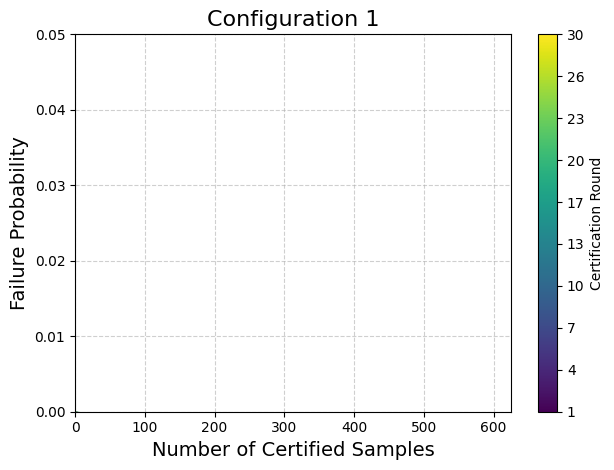

C:\Users\QILIP6\AppData\Local\Temp\ipykernel_17136\3420641768.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


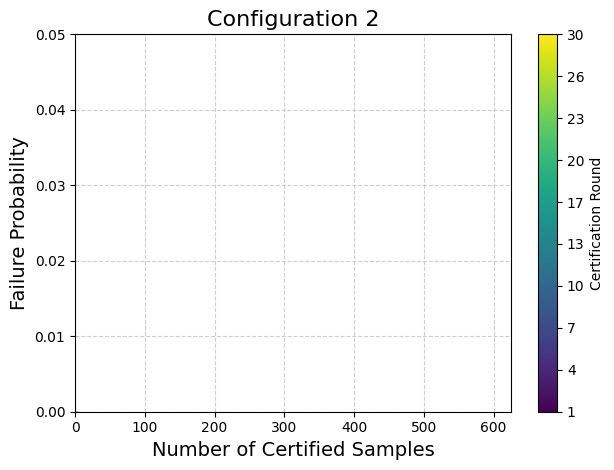

C:\Users\QILIP6\AppData\Local\Temp\ipykernel_17136\3420641768.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


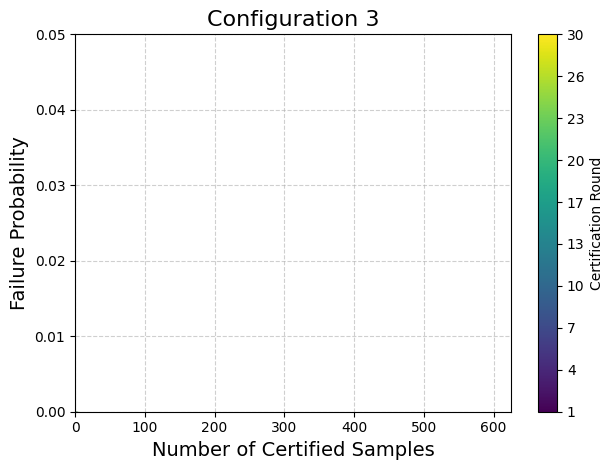

Mean Final failure probabilities [0.4381, 0.4387, 0.4364]


In [11]:
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, n_rounds))

############# Plotting the failure rate ##############
final_p_fail_mean = []
for index, file in enumerate(filenames):
    for i in range(n_rounds):
        ### Plotting the failure rate evolution for each verification round
        ### There is something weird with the dimensions
        x_data = n_samples_evolution[index][i]
        y_data = p_fail_evolution[index][i]

        plt.scatter(x_data, y_data,
                    s = 1,  # Increase scatter size
                    alpha = 0.03,  # Reduce point opacity for clarity
                    label = f"Dataset {i + 1}",
                    color = colors[i])  # Dynamic legend labels
        
    final_p_fail_mean.append(np.round(np.average(p_fail_evolution[index], axis = 0)[-1], 4))

    ### Plotting the mean failure rate evolution over all verification rounds
    p_fail_average_evolution = np.average(p_fail_evolution[index], axis=0)
    y_data_average = p_fail_average_evolution[:-1]
    x_data = np.arange(0, len(y_data_average))
    plt.scatter(x_data, y_data_average,
                s = 5,  # Increase scatter size
                alpha = 1,  # Reduce point opacity for clarity
                color = 'r',
                label = f"Dataset {i + 1}")  # Dynamic legend labels

    # Customize plot
    # Create a ScalarMappable to serve as the colorbar
    norm = mpl.colors.Normalize(vmin=1, vmax=n_rounds)  # Normalize to match the rounds
    sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Required for the colorbar

    # Add the colorbar
    cbar = plt.colorbar(sm)
    cbar.set_label("Certification Round")  # Label for colorbar
    cbar.set_ticks(np.linspace(1, n_rounds, min(n_rounds, 10)))  # Adjust ticks for clarity
    cbar.set_ticklabels([f"{int(i)}" for i in np.linspace(1, n_rounds, min(n_rounds, 10))])  # Custom labels

    plt.xlim(0, 625)  # Refine x-axis limits
    # plt.legend()
    plt.ylim(0,0.05)
    plt.grid(True, linestyle="--", alpha=0.6)  # Light gridlines
    plt.xlabel("Number of Certified Samples", fontsize=14)  # X-axis label
    plt.ylabel("Failure Probability", fontsize=14)  # Y-axis label
    plt.title(f"Configuration {index+1}", fontsize=16)  # Plot title
    plt.tight_layout()  # Avoid clipping
    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\with_Certification\Verification_Graph\Stab_Plus_1_r={index+1}.pdf", dpi=300)
    plt.show()

print("Mean Final failure probabilities", final_p_fail_mean)

In [ ]:
# [0.0085, 0.0088, 0.0195] for qubit = 0
# [0.0074, 0.0079, 0.0173] for qubit = 1